<a href="https://colab.research.google.com/github/Zhengwen-Lan/demo-repo/blob/main/%E5%88%86%E7%B1%BB%E9%A2%84%E6%B5%8B%EF%BC%88%E6%96%B0%E6%95%B0%E6%8D%AE%E9%9B%86%EF%BC%89%E4%B8%89%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 723 kB/s 


In [2]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
# import wget
from pathlib import Path
from pylab import mpl

## 数据集分割

In [3]:
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [4]:
train = pd.read_csv('/content/bagging_feature.csv')

In [5]:
strlist = ['病灶位置是否右中（1=是，0=否）',
           '首诊时有无发热（0=否，1=是）',
           '病灶位置是否右上（1=是，0=否）',
           '病灶位置是否左上（1=是，0=否）',
           '骨质增生（0=无骨质增生,1=骨质增生,2=骨质增生+椎间盘退变）',
           '是否有肺泡实变（GGO、均匀高密度影）（1（≤25%），2（>25%,≤50%）3（>50%，≤75%），4（≥75%），0=无）']

In [6]:
train[strlist] = train[strlist].astype(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 17 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   年龄（岁）                                                              451 non-null    float64
 1   首次查体体温（℃）                                                          451 non-null    float64
 2   肺动脉主干                                                              451 non-null    float64
 3   同层腹主短径                                                             451 non-null    float64
 4   首次检查全部病灶占全肺体积占比(%)                                                 451 non-null    float64
 5   心胸比比值(%)                                                           451 non-null    float64
 6   脾厚径（mm）                                                            451 non-null    float64
 7   下腔腹主比比值(%)                

In [7]:

target = 'classByDays'
# if "Set" not in train.columns:
#     train["Set"] = np.random.choice(["train", "test"], p =[.8, .2], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
# valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [8]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes != object]:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

病灶位置是否右中（1=是，0=否） 3
首诊时有无发热（0=否，1=是） 3
病灶位置是否右上（1=是，0=否） 3
病灶位置是否左上（1=是，0=否） 3
骨质增生（0=无骨质增生,1=骨质增生,2=骨质增生+椎间盘退变） 4
是否有肺泡实变（GGO、均匀高密度影）（1（≤25%），2（>25%,≤50%）3（>50%，≤75%），4（≥75%），0=无） 5
Set 2


# Define categorical features for categorical embeddings

In [9]:
unused_feat = ['Set','day_hospitalized']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
# cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10,1,2,3]

# Network parameters

In [10]:
from pytorch_tabnet.tab_model import TabNetClassifier
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=1e-1),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.95},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"'entmax'
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [11]:
train.head(20)

,年龄（岁）,首次查体体温（℃）,肺动脉主干,同层腹主短径,首次检查全部病灶占全肺体积占比(%),心胸比比值(%),脾厚径（mm）,下腔腹主比比值(%),甲状腺左叶面积（mm2）,病灶位置是否右中（1=是，0=否）,首诊时有无发热（0=否，1=是）,病灶位置是否右上（1=是，0=否）,病灶位置是否左上（1=是，0=否）,"骨质增生（0=无骨质增生,1=骨质增生,2=骨质增生+椎间盘退变）","是否有肺泡实变（GGO、均匀高密度影）（1（≤25%），2（>25%,≤50%）3（>50%，≤75%），4（≥75%），0=无）",classByDays,Set
0,36.0,37.5,24.0,17.6,0.86,68.343816,32.5,92.613636,194.9,0,1,0,1,3,1,2,1
1,34.0,36.6,26.9,15.5,0.00,60.173160,32.6,89.677419,192.5,0,0,0,0,3,0,2,1
2,29.0,37.1,26.2,17.0,0.33,43.656867,36.3,81.764706,73.4,2,1,2,2,1,1,1,1
3,64.0,37.3,29.2,23.3,53.07,59.680365,27.9,113.733906,109.0,1,1,1,1,2,3,3,1
4,34.0,37.1,26.3,18.3,0.79,42.448464,46.5,85.792350,189.7,1,2,0,0,0,1,2,1
5,34.0,37.1,23.1,17.2,1.39,41.922802,37.6,108.720930,150.3,1,2,0,0,0,1,2,1
6,34.0,37.1,28.7,19.1,0.92,48.109413,47.5,80.104712,182.9,0,2,0,1,0,1,2,1
7,32.0,37.7,28.3,19.8,0.88,46.979332,32.3,59.595960,184.0,1,1,1,1,1,1,2,0
8,45.0,37.9,23.5,22.9,0.06,46.738266,28.3,87.772926,178.3,1,1,0,0,1,1,3,0
9,55.0,36.9,23.2,21.1,2.50,46.205171,28.5,80.568720,152.4,1,0,0,0,2,1,2,1


# Training

In [12]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]


# X_valid = train[features].values[valid_indices]
# y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

print(X_train.shape, y_test.shape)

(365, 15) (86,)


# FIT

In [13]:
max_epochs = 2000 if not os.getenv("CI", False) else 2
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    max_epochs=max_epochs, patience=80,
    batch_size=128, virtual_batch_size=16,
    augmentations=aug
) 

epoch 0  | loss: 1.39558 | train_accuracy: 0.6137  | test_accuracy: 0.60465 |  0:00:00s
epoch 1  | loss: 0.91853 | train_accuracy: 0.55342 | test_accuracy: 0.52326 |  0:00:00s
epoch 2  | loss: 0.99921 | train_accuracy: 0.47945 | test_accuracy: 0.44186 |  0:00:00s
epoch 3  | loss: 0.95855 | train_accuracy: 0.21096 | test_accuracy: 0.22093 |  0:00:00s
epoch 4  | loss: 0.88001 | train_accuracy: 0.57534 | test_accuracy: 0.53488 |  0:00:00s
epoch 5  | loss: 0.93417 | train_accuracy: 0.61644 | test_accuracy: 0.59302 |  0:00:00s
epoch 6  | loss: 0.92917 | train_accuracy: 0.61918 | test_accuracy: 0.60465 |  0:00:00s
epoch 7  | loss: 0.90857 | train_accuracy: 0.60822 | test_accuracy: 0.60465 |  0:00:00s
epoch 8  | loss: 0.91186 | train_accuracy: 0.61096 | test_accuracy: 0.60465 |  0:00:00s
epoch 9  | loss: 0.90821 | train_accuracy: 0.61644 | test_accuracy: 0.59302 |  0:00:00s
epoch 10 | loss: 0.93325 | train_accuracy: 0.56712 | test_accuracy: 0.53488 |  0:00:01s
epoch 11 | loss: 0.91536 | train

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Prediction

BEST TEST SCORE FOR  : 0.6627906976744186


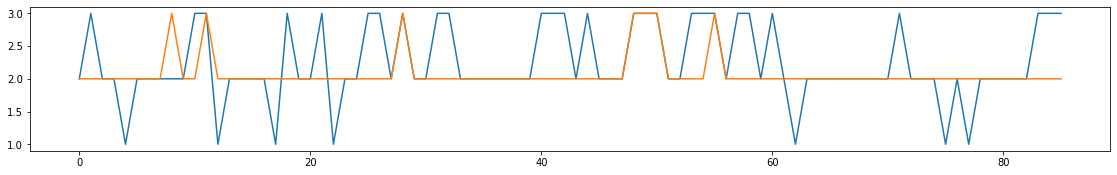

TEST ACCURACY : 0.6627906976744186


In [14]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)
y_true = y_test

# 过拟合
# preds = clf.predict(X_train)
# y_true = y_train

# test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST TEST SCORE FOR  : {clf.best_cost}")
# print(f"FINAL TEST SCORE FOR  : {test_score}")

import matplotlib.pyplot as plt
plt.axes([0, 0, 2.5, 0.5])
plt.plot(y_true)
plt.plot(preds)

plt.show()

from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_pred=preds, y_true=y_test)
print(f"TEST ACCURACY : {test_acc}")

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23618 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30701 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24452 missing from current font.
  font.set_

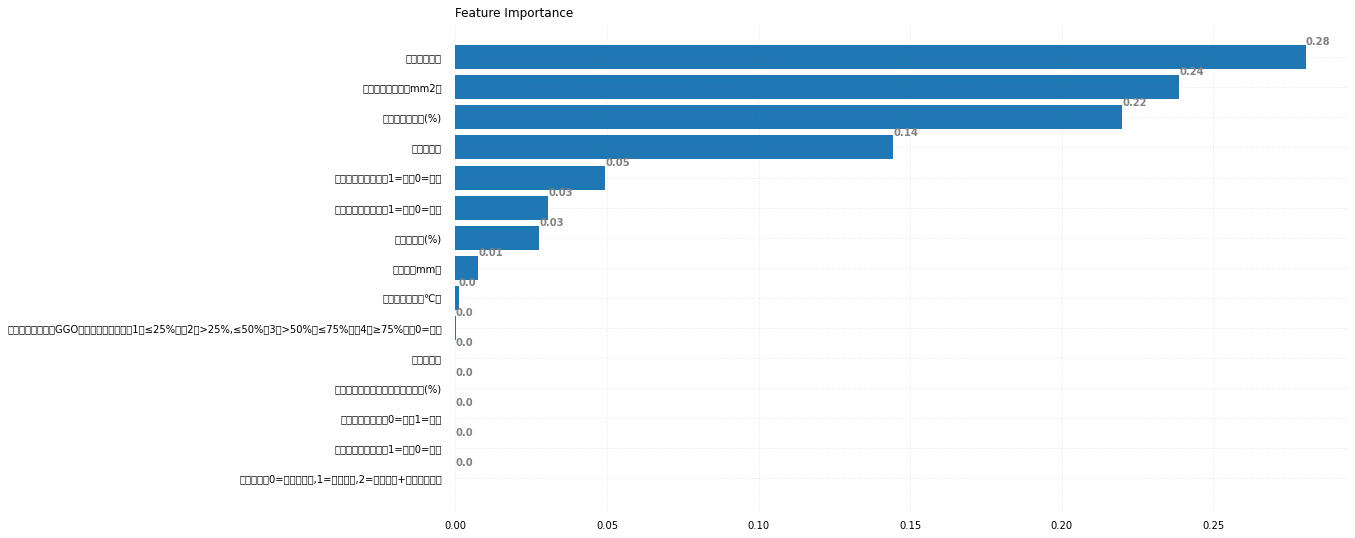

In [15]:

raw_X_train = train[features]
feature_name = list(raw_X_train.columns)


importance_list = pd.DataFrame(
    {'feature_name': feature_name,
     'value': list(clf.feature_importances_),
    })
importance_list = importance_list.sort_values('value',ascending=False)
name = importance_list['feature_name']
price = importance_list['value']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(name, price)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y(),
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Feature Importance',
             loc ='left', )

# Add Text watermark
# fig.text(0.9, 0.15, 'feature_importance', fontsize = 12,
#          color ='grey', ha ='right', va ='bottom',
#          alpha = 0.7)

# Show Plot
plt.show()

In [16]:
print(preds)
print(y_true)

[2 2 2 2 2 2 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]
[2 3 2 2 1 2 2 2 2 2 3 3 1 2 2 2 2 1 3 2 2 3 1 2 2 3 3 2 3 2 2 3 3 2 2 2 2
 2 2 2 3 3 3 2 3 2 2 2 3 3 3 2 2 3 3 3 2 3 3 2 3 2 1 2 2 2 2 2 2 2 2 3 2 2
 2 1 2 1 2 2 2 2 2 3 3 3]


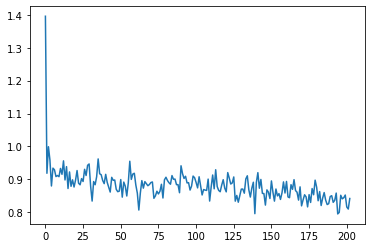

In [17]:
# plot losses
plt.plot(clf.history['loss'])

In [18]:
# plot accuracy
# plt.plot(clf.history['train_auc'])
# plt.plot(clf.history['test_auc'])

In [19]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]
from sklearn.metrics import accuracy_score

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR  : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR  : {test_acc}")

BEST VALID SCORE FOR  : 0.6627906976744186
FINAL TEST SCORE FOR  : 0.6627906976744186


In [20]:
# or you can simply use the predict method


y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR  : {test_acc}")

FINAL TEST SCORE FOR  : 0.6627906976744186
